In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


colab_env = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
colab_initialized = True if os.path.exists("MotorNet") else False

if colab_env and not colab_initialized:
  !git clone https://github.com/OlivierCodol/MotorNet
  sys.path.append('MotorNet')
  print("Running cell using COLAB initialization...")
elif colab_env and colab_initialized:
  print("Already initialized using COLAB initialization.")
else:
  paths = [p for p in sys.path if os.path.exists(p)]
  local_initialized = True if [p for p in paths if "motornet" in os.listdir(p)] else False
  if local_initialized:
    %load_ext autoreload
    %autoreload 2
    print("Already initialized using LOCAL initialization.")
  else:
    path = [p for p in paths if p.__contains__("tutorials")]
    if len(path) != 1:
      raise ValueError("Path to MotorNet could not be determined with certainty.")
    sys.path.append(os.path.dirname(path[:path.rfind('tutorials')]))
    %load_ext autoreload
    %autoreload 2
    print("Running cell using LOCAL initialization...")


import motornet as mn


def simulate_motion(plant, excitation_pattern, movement_duration):
    j_state, _, m_state, g_state = plant.get_initial_state(joint_state=tf.zeros((1, 4)))
    j = j_state
    m = m_state
    g = g_state

    t_fn = np.arange(0., movement_duration, plant.dt)
    excitation = tf.ones((1, plant.n_muscles)) * excitation_pattern

    for _ in range(len(t_fn)):
        j, c, m, g = plant(excitation, j, m, g)
        j_state = tf.concat([j_state, j], axis=0)
        m_state = tf.concat([m_state, m], axis=0)
        g_state = tf.concat([g_state, g], axis=0)

    return j_state, m_state, g_state


def plot_motion(j_state, g_state, plant, movement_duration):
    t_fn = np.arange(0., movement_duration + plant.dt, plant.dt)

    plt.subplot(131)
    plt.plot(t_fn, j_state[:, 0], label='x')
    plt.plot(t_fn, j_state[:, 1], label='y', linestyle=':', linewidth=3)
    plt.ylabel('position (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(132)
    plt.plot(t_fn, g_state[:, 0, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, g_state[:, 0, 1], label=plant.muscle_name[1])
    plt.plot(t_fn, g_state[:, 0, 2], label=plant.muscle_name[2], linestyle=':', linewidth=3)
    plt.plot(t_fn, g_state[:, 0, 3], label=plant.muscle_name[3])
    plt.ylabel('musculotendon length (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(133)
    plt.plot(t_fn, g_state[:, 1, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, g_state[:, 1, 1], label=plant.muscle_name[1])
    plt.plot(t_fn, g_state[:, 1, 2], label=plant.muscle_name[2], linestyle='--')
    plt.plot(t_fn, g_state[:, 1, 3], label=plant.muscle_name[3], linestyle=':')
    plt.ylabel('musculotendon velocity (m/sec)')
    plt.xlabel('time (sec)')
    plt.legend()


def print_muscle_states(plant, states):
    state_idx = 0

    for m in range(plant.n_muscles):
        muscle = plant.muscle
        muscle_name = plant.muscle_name[m]
        print('\ninitial ' + muscle_name + ' state:\n')
        state_m = states[:, state_idx:state_idx + plant.muscle_state_dim]
        state_idx += plant.muscle_state_dim

        for j in range(plant.muscle_state_dim):
            state_name = muscle.state_name[j]
            print(state_name + ' = ' + str(states[:, j, m].numpy()))


def plot_muscle_states(plant, states, movement_duration):
    n_muscle_states = plant.muscle_state_dim
    t_plot = np.arange(0., movement_duration + plant.dt, plant.dt)
    for j in range(n_muscle_states):
        plt.subplot(3, 4, j+1)
        plt.plot(t_plot, states[:, j, 0], label=plant.muscle_name[0])
        plt.plot(t_plot, states[:, j, 1], label=plant.muscle_name[1], linestyle=':', linewidth=3.)
        plt.title(plant.muscle.state_name[j])
        plt.xlabel('time (sec)')
    plt.legend()


print('All packages imported.')
print('tensorflow version: ' + tf.__version__)
print('numpy version: ' + np.__version__)


Already initialized using LOCAL initialization.
All packages imported.
tensorflow version: 2.9.1
numpy version: 1.22.4


# I. Introduction
In this notebook, we will build a 2D point-mass system for each muscle type and see how each muscle type behave to ensure they work properly. The point-mass will be tied to 4 muscles forming a X shaped, as illustrated below.

<img src="img/pointmass.png" alt="drawing" width="300"/>

The 2D point-mass is the simplest skeleton possible, making it a good toy model to assess how each muscle class works. It is recommended to check the ```build-plant.ipynb``` notebook for a more detailed explanation on how to build a full plant.

# II. ReLu muscles

We can start by using simple ReLu muscles. ReLu muscles are "rectified linear" muscles whose force output is a linear function of their activation value, which itself is bounded between 0 and 1. The force output is scaled by the muscle's (user-defined) maximum isometric force, meaning an activation of 1 will yield their maximum isometric force.

In the example illustrated above, each muscle is a simple one-segment muscle, so we have two fixation points (start and end). Any fixation point must be fixed on a specific body (bone), which must be declared by the user. For instance, a mono-articular elbow muscle would have one fixation point on the upper arm bone and one fixation point on the forearm bone. Besides bones, the worldspace is also a possible fixation body, so that a bone may be moved with respect to the worldspace rather than with respect to another bone alone. The index of the worldspace is always 0, and each bone is indexed with increasing numbers depending on their connection order. For instance, an upper arm bone is linked to the worldspace (so the index is 1) and a forearm bone is linked to the upper arm bone (index is 2).

Here the first fixation point is different for each muscle because they link to different points on the worldspace, but their last fixation point is the same since they all contact the same point-mass at its center.

For the fourth muscle, we will use three fixation points, with the first two linked to the worldspace. In effect this should not change the moment arms, but it should increase muscle lengths. This will allow us to test if the plant geometry is working properly.

In [2]:


# create the point-mass and associated muscles
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.ReluMuscle()
relu_plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type)


# PointMass skeletons only have one "bone", which is the point itself.
relu_plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[2, 2], [0, 0]], name='UpRight', max_isometric_force=500)
relu_plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, 2], [0, 0]], name='UpLeft', max_isometric_force=500)
relu_plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-2, -2], [0, 0]], name='DownLeft', max_isometric_force=500)

# Three-points muscle
relu_plant.add_muscle(path_fixation_body=[0, 0, 1], path_coordinates=[[4, -2], [2, -2], [0, 0]], name='DownRight', max_isometric_force=500)

print('Plant model created.')


Plant model created.


## II. 1. Inspecting initial muscle states

Muscle states should have a shape of ```(batch_size, n_features, n_muscles)```. The (ordered) list of features is always available in the ```Muscle.state_name``` attribute.

First let's try random starting positions (the default when you use `plant.get_initial_state`) for a batch size of 2. All values should be 0, except for the muscle length, which should vary randomly depending on the (randomly drawn) starting position.

In [3]:

states = relu_plant.get_initial_state(batch_size=2)
# joint_state, cartesian_state, muscle_state, geometry_state = states
_, _, muscle_state, _ = states
print('Features for a ReLu muscle:\n' + str(relu_plant.muscle.state_name) + '\n\n')
print('initial muscle state:\n' + str(muscle_state) + '\n')


Features for a ReLu muscle:
['activation', 'muscle length', 'muscle velocity', 'force']


initial muscle state:
tf.Tensor(
[[[0.        0.        0.        0.       ]
  [2.8679533 1.8578935 3.1162992 5.8058777]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]

 [[0.        0.        0.        0.       ]
  [3.7152045 2.9022923 1.943293  5.025861 ]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]], shape=(2, 4, 4), dtype=float32)



We can see that we have a shape `(2, 4, 4)`, meaning two examples (since the batch size is 2), for 4 states (muscle activation, length, velocity, and force) for 4 muscles.

Now let us try when we manually enforce a starting position at the center of the workspace (`[x, y] = [0, 0]`).
The muscle length should be identical for all batches and all muscles.
To do so, we input a ``joint_state`` argument to the `plant.get_initial_state` method, which is an array of zeros.
Joint states have a shape of ```(batch_size, n_features)```, with the features always being joint position and joint velocity. Now, a point-mass doesn't really have joints, and it evolves in cartesian space directly. So for a point-mass, the features would be `[x position, y position, x velocity, y velocity]`.



In [4]:
joint_state = tf.zeros((2, 4))  # batch of 2 for 4 features.
states = relu_plant.get_initial_state(joint_state=joint_state)
print('initial muscle state:\n' + str(states[2]) + '\n')


initial muscle state:
tf.Tensor(
[[[0.        0.        0.        0.       ]
  [2.828427  2.828427  2.828427  4.8284273]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]

 [[0.        0.        0.        0.       ]
  [2.828427  2.828427  2.828427  4.8284273]
  [0.        0.        0.        0.       ]
  [0.        0.        0.        0.       ]]], shape=(2, 4, 4), dtype=float32)



## II. 2. Simulating motion

In the 1st simulation run we excite only the muscle pulling to the up-right corner. Let's do a 150 ms movement.

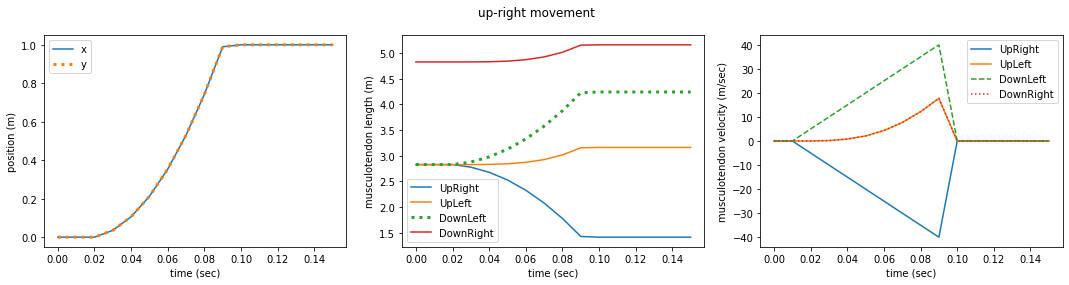

In [5]:
# up-right movement
#--------------------------------

t_end = 0.15
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, _, geometry_state = simulate_motion(relu_plant, [1, 0, 0, 0], t_end)
plot_motion(joint_state, geometry_state, relu_plant, t_end)
plt.suptitle('up-right movement')
plt.show()


On the left panel, we can see that the point-mass is moving to the up-right corner (increase in x and y position). On the middle panel, the muscle (musculotendon complex) being excited shortens while the other ones are elongated by the pull of the UpRight muscle. Finally, on the right panel, we can see that the muscle velocity of the shortening muscle is negative (indicating shortening velocity), while that of the other ones is positive (elongating velocity).

In the 2nd simulation run we excite the muscle pulling to the right and down.

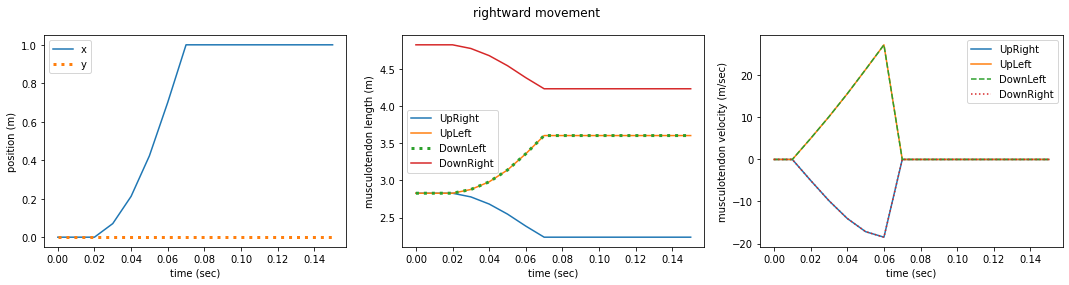

In [6]:
# rightward movement
#--------------------------------

t_end = 0.15
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, _, geometry_state = simulate_motion(relu_plant, [1, 0, 0, 1], t_end)
plot_motion(joint_state, geometry_state, relu_plant, t_end)
plt.suptitle('rightward movement')
plt.show()


In the 3rd simulation run we excite all four muscles at the same time, for an isometric co-contraction. None of the
path lengths should change.

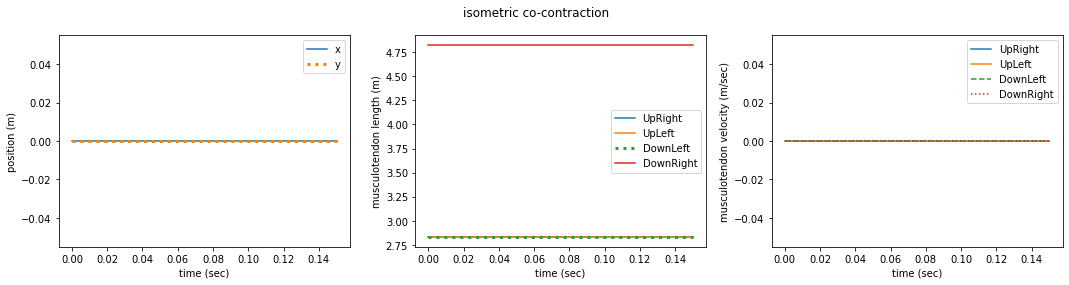

In [7]:
# Isometric co-contraction
#--------------------------------

t_end = 0.15
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, _, geometry_state = simulate_motion(relu_plant, [1, 1, 1, 1], t_end)
plot_motion(joint_state, geometry_state, relu_plant, t_end)
plt.suptitle('isometric co-contraction')
plt.show()


# III. Hill muscles (Kistemaker version)

The first Hill muscle type we look at is the implementation from [Kistemaker et al., 2006](https://www.physiology.org/doi/10.1152/jn.00983.2005) and [Kistemaker et al., 2010](https://www.physiology.org/doi/10.1152/jn.00483.2010).

## III. 1. Muscle states

Let's look at the variables included in the muscle state. To do so, we first build the plant and create a dummy muscle.
Note that we define a `max_isometric_force` of 1 to observe the force development curves in a normalized situation.

In [8]:

skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[1,1], [0,0]],
    max_isometric_force=1,
    tendon_length=0.,
    optimal_muscle_length=0.4)
muscle = plant.muscle


print('Features for a Hill type muscle:\n' + str(muscle.state_name) + '\n\n')


Features for a Hill type muscle:
['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']





## III. 2. Muscle force development curves

Next, let's assess what the force production curves look like. Hill-type muscles consist of an active and passive length-force relationship.

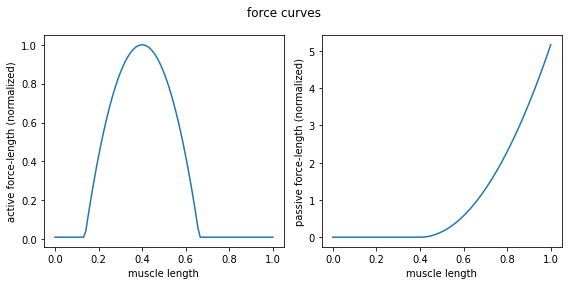

In [9]:



n_points = 100

m = tf.zeros((n_points, plant.muscle_state_dim, plant.n_muscles))
deriv = muscle.update_ode(excitation=0., muscle_state=m)

# Each batch entry contains a different musculotendon length.
# Since the tendon length is set to 0, the musculotendon length is the same as
#  the muscle length in this particular example.
muscle_len = np.linspace(0.,1., n_points).reshape((-1,1,1))
zeros = np.zeros((n_points, plant.geometry_state_dim-1, plant.n_muscles))
g =  tf.convert_to_tensor(np.concatenate([muscle_len, zeros], axis=1))

states = muscle.integrate(dt=plant.dt, state_derivative=deriv, muscle_state=m, geometry_state=g)


plt.figure(figsize=(8, 4)).set_tight_layout(True)
plt.suptitle('force curves')
x = muscle_len.reshape(-1,1)

plt.subplot(121)
plt.plot(x, states[:, 4, :])
plt.xlabel('muscle length')
plt.ylabel('active force-length (normalized)')

plt.subplot(122)
plt.plot(x, states[:, 3, :])
plt.xlabel('muscle length')
plt.ylabel('passive force-length (normalized)')

plt.show()


## III. 3. Inspecting initial states

First, let's try random starting positions (the default when you use `plant.get_initial_state`).


In [10]:
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.001)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpLeft')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownLeft')


states = plant.get_initial_state(batch_size=4)
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [2.6718633 2.8568113 2.4446187 1.8789387]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.         0.00023119 0.         0.        ]
force-length CE = [0.99296594 0.99976873 0.9577282  0.741297  ]
force-velocity CE = [0.00099297 0.00099977 0.00095773 0.0007413 ]
force = [0.0496483  0.06154812 0.04788641 0.03706485]

initial UpLeft state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [3.791508  2.6685977 3.218425  2.8890417]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.266163   0.         0.04364625 0.00105433]
force-length CE = [0.73383707 0.9926694  0.95635366 0.99894553]
force-velocity CE = [0.00073384 0.00099267 0.00095635 0.00099895]
force = [13.344841    0.04963347  2.2301302   0.10266376]

initial DownRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [1.9086475 2.9884593 2.4988139 3.0801158]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.         0.00734

Now let us try when the point mass starts in the center of the workspace (`[x, y] = [0, 0]`).

In [11]:

joint_state = tf.zeros((2, 4))
states = plant.get_initial_state(joint_state=joint_state)
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001]
muscle length = [2.828427 2.828427]
muscle velocity = [0. 0.]
force-length PE = [0. 0.]
force-length CE = [1. 1.]
force-velocity CE = [0.001 0.001]
force = [0.05 0.05]

initial UpLeft state:

activation = [0.001 0.001]
muscle length = [2.828427 2.828427]
muscle velocity = [0. 0.]
force-length PE = [0. 0.]
force-length CE = [1. 1.]
force-velocity CE = [0.001 0.001]
force = [0.05 0.05]

initial DownRight state:

activation = [0.001 0.001]
muscle length = [2.828427 2.828427]
muscle velocity = [0. 0.]
force-length PE = [0. 0.]
force-length CE = [1. 1.]
force-velocity CE = [0.001 0.001]
force = [0.05 0.05]

initial DownLeft state:

activation = [0.001 0.001]
muscle length = [2.828427 2.828427]
muscle velocity = [0. 0.]
force-length PE = [0. 0.]
force-length CE = [1. 1.]
force-velocity CE = [0.001 0.001]
force = [0.05 0.05]


## III. 4. Simulating motion
In the 1st simulation run, we excite only the muscle pulling to the upper right corner.

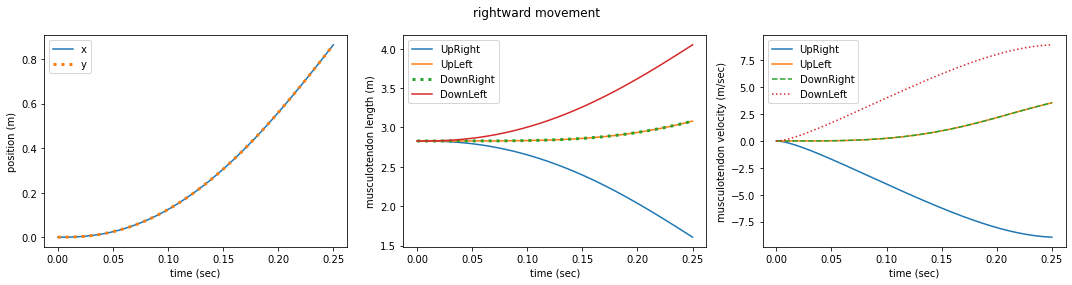

In [12]:

t_end = 0.25
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 0., 0., 0.], t_end)
plot_motion(joint_state, geometry_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()


We can observe the states changing over time below. Only the upper right and upper left muscles are plotted for the sake of simplicity.


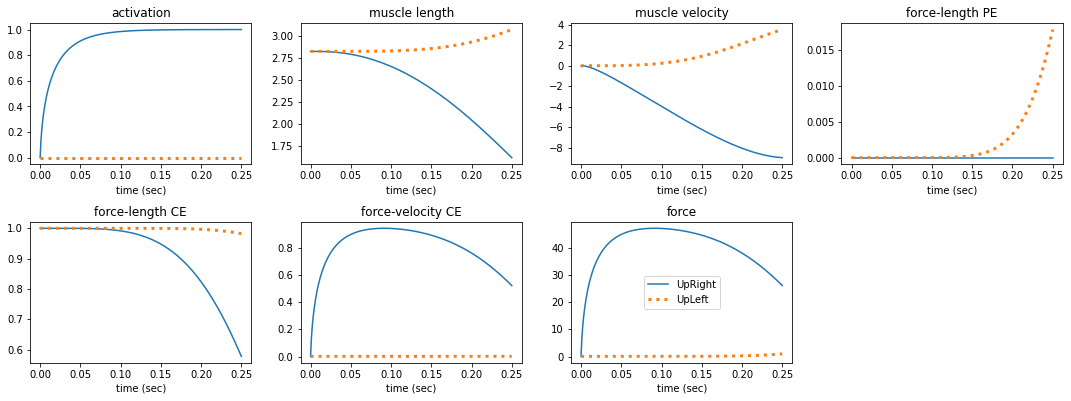

In [13]:


plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)


In the second simulation run we excite all four muscles at the same time, for an isometric co-contraction. Here none of the
path lengths should change.

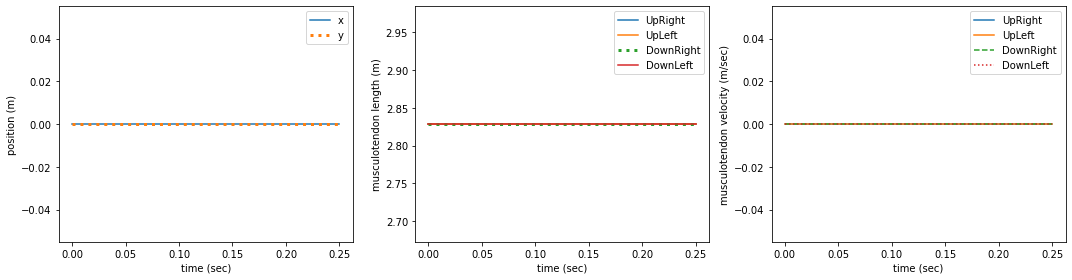

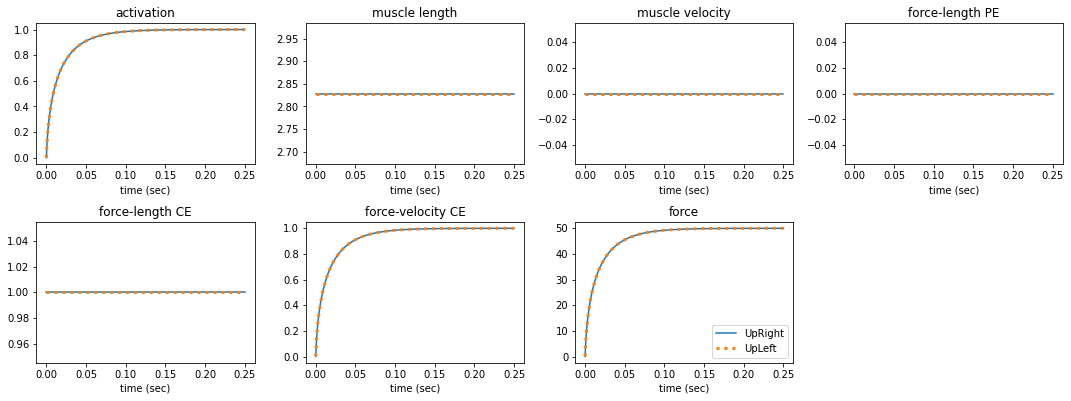

In [14]:
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 1., 1., 1.], t_end)

plt.figure(figsize=(15, 4)).set_tight_layout(True)
plot_motion(joint_state, geometry_state, plant, t_end)

plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)

# IV. Hill muscles (Thelen version)

The Thelen version of a Hill-type muscle is detailed in [Thelen et al., 2003](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Thelen+2003+Muscle+Model).

## IV. 1. Muscle states

In [15]:
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscleThelen()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[1,1], [0,0]],
    max_isometric_force=1,
    tendon_length=0.,
    optimal_muscle_length=0.4)
muscle = plant.muscle


print('Features for a Thelen Hill muscle:\n' + str(muscle.state_name) + '\n\n')

Features for a Thelen Hill muscle:
['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']




## IV. 2. Muscle force development curves

Two key differences can be observed compared to the *Kistemaker* Hill-type muscle.
- The force-length curve does not reach 0 in the Thelen muscle.
- Passive forces increase much faster in the Thelen muscle, as its formulation is an exponential function instead of a quadriatic function.


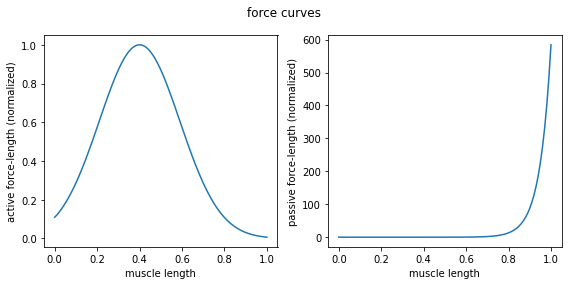

In [16]:


n_points = 100

m = tf.zeros((n_points, plant.muscle_state_dim, plant.n_muscles))
deriv = muscle.update_ode(excitation=0., muscle_state=m)

# Each batch entry contains a different musculotendon length.
# Since the tendon length is set to 0, the musculotendon length is the same as
#  the muscle length in this particular example.
muscle_len = np.linspace(0.,1., n_points).reshape((-1,1,1))
zeros = np.zeros((n_points, plant.geometry_state_dim-1, plant.n_muscles))
g =  tf.convert_to_tensor(np.concatenate([muscle_len, zeros], axis=1))

states = muscle.integrate(dt=plant.dt, state_derivative=deriv, muscle_state=m, geometry_state=g)


plt.figure(figsize=(8, 4)).set_tight_layout(True)
plt.suptitle('force curves')
x = muscle_len.reshape(-1,1)

plt.subplot(121)
plt.plot(x, states[:, 4, :])
plt.xlabel('muscle length')
plt.ylabel('active force-length (normalized)')

plt.subplot(122)
plt.plot(x, states[:, 3, :])
plt.xlabel('muscle length')
plt.ylabel('passive force-length (normalized)')

plt.show()

## IV. 3. Inspecting initial states

Similar to the Kistemaker Hill muscle, let us first look at random initial states.

In [17]:
skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.RigidTendonHillMuscleThelen()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.001)

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='UpLeft')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownRight')

plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[-2,-2], [0,0]],
    max_isometric_force=50,
    tendon_length=0.,
    optimal_muscle_length= np.sqrt(2 * (2 ** 2)),
    name='DownLeft')


states = plant.get_initial_state(batch_size=4)
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [1.9468753 2.449389  3.2725842 2.1201596]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.         0.         0.01550688 0.        ]
force-length CE = [0.8058398  0.96087754 0.94667566 0.86992764]
force-velocity CE = [1. 1. 1. 1.]
force = [0.04029199 0.04804388 0.82267755 0.04349639]

initial UpLeft state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [3.204291  3.282889  2.3154924 3.2060525]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.0117807  0.01613067 0.         0.01186849]
force-length CE = [0.96151733 0.9442437  0.9295229  0.9611629 ]
force-velocity CE = [1. 1. 1. 1.]
force = [0.6371108  0.85374594 0.04647614 0.6414827 ]

initial DownRight state:

activation = [0.001 0.001 0.001 0.001]
muscle length = [2.7323444 2.436419  3.3992188 2.637385 ]
muscle velocity = [0. 0. 0. 0.]
force-length PE = [0.         0.         0.02450778 0.        ]
force-length CE = [0.99743885 0.9582121  

Now let us try when the point mass starts in the center of the workspace (`[x, y] = [0, 0]`).

In [18]:
states = plant.get_initial_state(joint_state=tf.zeros((3, 2)))
print_muscle_states(plant, states[2])



initial UpRight state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]

initial UpLeft state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]

initial DownRight state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]

initial DownLeft state:

activation = [0.001 0.001 0.001]
muscle length = [2.828427 2.828427 2.828427]
muscle velocity = [0. 0. 0.]
force-length PE = [0. 0. 0.]
force-length CE = [1. 1. 1.]
force-velocity CE = [1. 1. 1.]
force = [0.05 0.05 0.05]


## IV. 4. Simulating motion
In the 1st simulation run, we excite only the muscle pulling to the upper right corner.


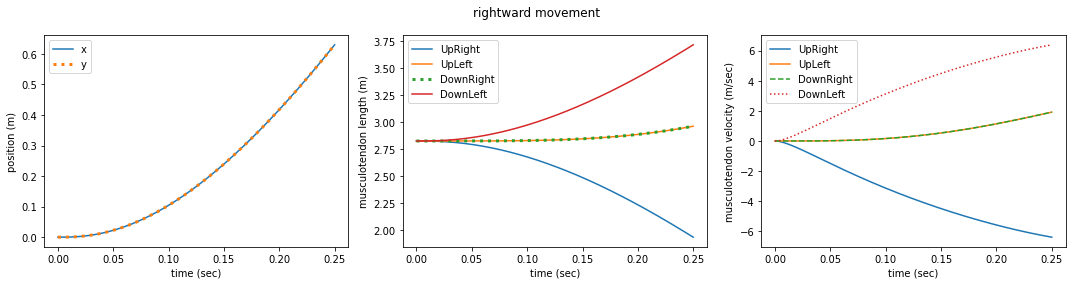

In [19]:
t_end = 0.25
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 0., 0., 0.], t_end)
plot_motion(joint_state, geometry_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()

We can observe the states changing over time below. Only the upper right and upper left muscles are plotted for the sake of simplicity.

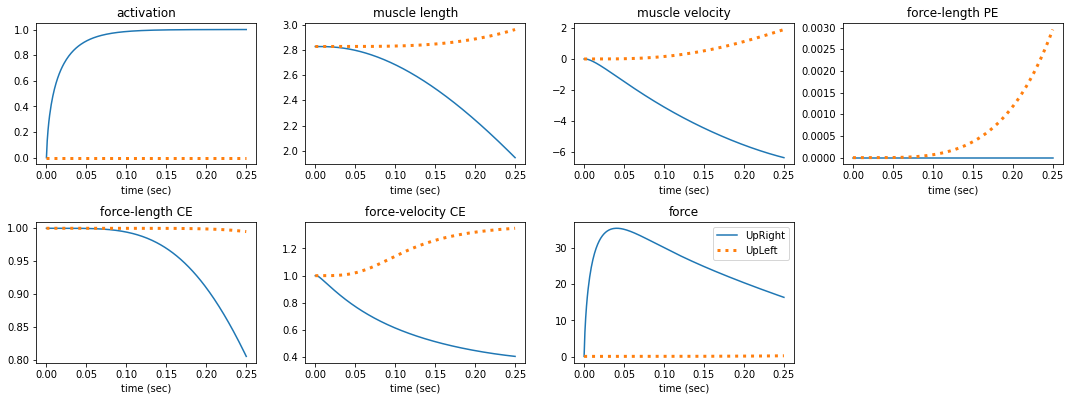

In [20]:

plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)


And finally, we simulate an isometric co-contraction of all muscles in the system.
Note that some variables are at floating point precision.

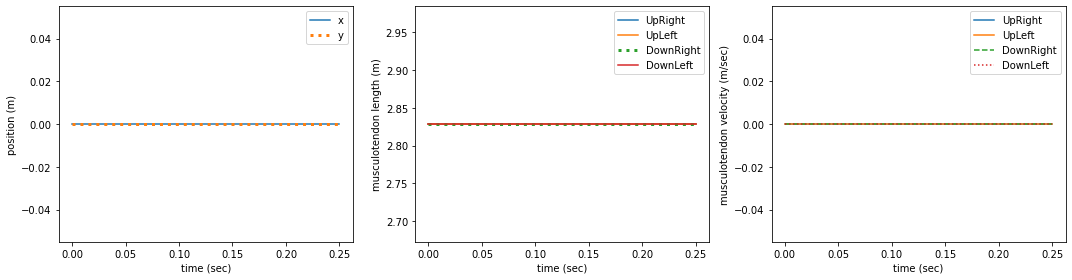

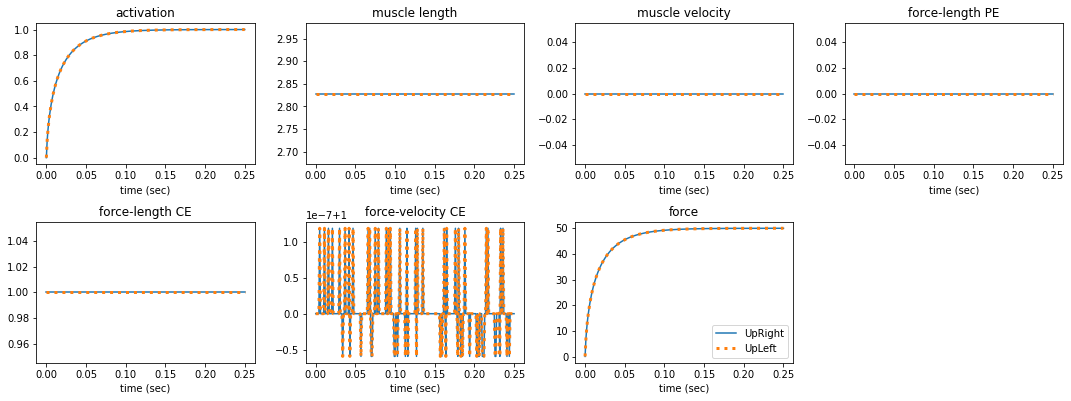

In [21]:
joint_state, muscle_state, geometry_state = simulate_motion(plant, [1., 1., 1., 1.], t_end)

plt.figure(figsize=(15, 4)).set_tight_layout(True)
plot_motion(joint_state, geometry_state, plant, t_end)

plt.figure(figsize=(15, 8)).set_tight_layout(True)
plot_muscle_states(plant, muscle_state, t_end)

# V. Compliant tendon Hill-type muscle (Kistemaker version)

The `CompliantTendonHillMuscle` class is an extention of the `RigidTendonHillMuscle` class to inclde a compliant tendon. In fact, the muscle model proposed in [Kistemaker et al., 2006](https://www.physiology.org/doi/10.1152/jn.00983.2005) and [Kistemaker et al., 2010](https://www.physiology.org/doi/10.1152/jn.00483.2010) includes a compliant tendon, and the `RigidTendonHillMuscle` class is a modified version of the original model formulation. Similarly, the `RigidTendonHillMuscleThelen` class is a modified version from the original, compliant-tendon version.

## V. 1. Muscle states
Let us first look at the state features.


In [22]:

skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.CompliantTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.0001)


# we make the tendon very long to reduce its stiffness
# and allow looking at the force production curves in more details
plant.add_muscle(
    path_fixation_body=[0, 1],
    path_coordinates=[[6,0], [0,0]],
    max_isometric_force=1,
    tendon_length=5,
    optimal_muscle_length=0.8)
muscle = plant.muscle


print('Features for a compliant tendon muscle:\n' + str(muscle.state_name) + '\n\n')


Features for a compliant tendon muscle:
['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length SE', 'active force', 'force']





## V. 2. Muscle force development curves
Compliant tendon muscles do not compute force-length curves directly. Rather, they make use of tendon forces and assume equilibrium between tendon and muscle forces to obtain output forces for a given muscle. Below we look at the tendon, muscle passive and active forces as a function of muscle length.

Note that the tendon is much stiffer than the passive muscle forces. Additionally, the tendon forces are capped at 1 to prevent the muscle from outputing more than its maximum isometric force. Finally, note how the active force reaches 0 faster than the tendon force, due to the overlap between tendon and passive forces leading to them cancelling each other in that region.


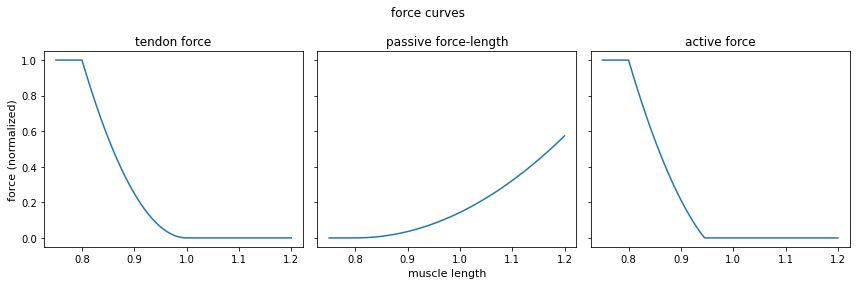

In [23]:

n_points = 100

# create muscle state
m = np.zeros((n_points, plant.muscle_state_dim, plant.n_muscles))
muscle_len = np.linspace(0.75, 1.2, n_points).reshape(-1, 1)
m[:, 1, :] = muscle_len
deriv = muscle.update_ode(excitation=0., muscle_state=m)

# create geometry state
zeros = np.zeros((n_points, plant.geometry_state_dim, plant.n_muscles))
zeros[:, 0, 0] = 6  # the musculotendon length is 6 m due to the way it was built above.
g = tf.convert_to_tensor(zeros)

states = muscle.integrate(dt=plant.dt, state_derivative=deriv, muscle_state=m, geometry_state=g)

#-----------
# plot
#-----------
fig, axs = plt.subplots(1, 3, sharey='all', sharex='all')
fig.set_tight_layout(True)
fig.set_size_inches(12, 4)
fig.suptitle('force curves')

x = muscle_len.reshape(-1,1)

axs[0].plot(x, states[:, 4, :])
axs[0].set_title('tendon force')
axs[0].set_ylabel('force (normalized)', fontsize=11)

axs[1].plot(x, states[:, 3, :])
axs[1].set_xlabel('muscle length', fontsize=11)
axs[1].set_title('passive force-length')

axs[2].plot(x, states[:, 5, :])
axs[2].set_title('active force')

plt.show()


## V. 3. Inspecting initial states

Let's use the pre-built `CompliantTendonArm26` plant object.


In [24]:

plant = mn.plants.CompliantTendonArm26()
states = plant.get_initial_state(batch_size=4)
print_muscle_states(plant, states[2])



initial pectoralis state:

activation = [0.01 0.01 0.01 0.01]
muscle length = [0.15584071 0.15417568 0.14954498 0.14946094]
muscle velocity = [-0.2257553  -0.2257553  -0.22573638 -0.2257553 ]
force-length PE = [0.06101203 0.05206589 0.03091257 0.03057938]
force-length SE = [0.06101166 0.0520646  0.03091281 0.03057874]
active force = [0.0000000e+00 0.0000000e+00 2.3655593e-07 0.0000000e+00]
force = [51.12777  43.630135 25.904936 25.624987]

initial deltoid state:

activation = [0.01 0.01 0.01 0.01]
muscle length = [0.12165862 0.12337634 0.12815358 0.12824027]
muscle velocity = [-0.2265748  -0.2282336  -0.23198983 -0.23204632]
force-length PE = [0. 0. 0. 0.]
force-length SE = [0. 0. 0. 0.]
active force = [0. 0. 0. 0.]
force = [0. 0. 0. 0.]

initial brachioradialis state:

activation = [0.01 0.01 0.01 0.01]
muscle length = [0.04904859 0.09875648 0.08834091 0.05121438]
muscle velocity = [-0.07744632 -0.1549745  -0.15443426 -0.08507071]
force-length PE = [0.         0.01239297 0.         0

And with fixed starting positions. Note that now that we are using a two-degrees of freedom arm, we use actual joint values (in radians) rather than `[0, 0]`.

There are two joints (shoulder and elbow), and so the second dimension of `joint_state` should also have 4 elements (two joint positions, two joint velocities). In the `plant.get_initial_state` method, if only half of the elements are passed for the feature dimension, it assumes the velocities are all 0.


In [25]:
joint_state = (np.pi/4) * tf.ones((2, 2))
states = plant.get_initial_state(joint_state=joint_state)
print_muscle_states(plant, states[2])


initial pectoralis state:

activation = [0.01 0.01]
muscle length = [0.1355095 0.1355095]
muscle velocity = [-0.22575533 -0.22575533]
force-length PE = [0.00029307 0.00029307]
force-length SE = [0.00029283 0.00029283]
active force = [0. 0.]
force = [0.24539474 0.24539474]

initial deltoid state:

activation = [0.01 0.01]
muscle length = [0.14255574 0.14255574]
muscle velocity = [-0.23585105 -0.23585105]
force-length PE = [0.00076788 0.00076788]
force-length SE = [0.00076804 0.00076804]
active force = [1.5646219e-07 1.5646219e-07]
force = [0.927022 0.927022]

initial brachioradialis state:

activation = [0.01 0.01]
muscle length = [0.09957521 0.09957521]
muscle velocity = [-0.15499091 -0.15499091]
force-length PE = [0.01557695 0.01557695]
force-length SE = [0.01557705 0.01557705]
active force = [9.778887e-08 9.778887e-08]
force = [22.150564 22.150564]

initial tricepslat state:

activation = [0.01 0.01]
muscle length = [0.06677533 0.06677533]
muscle velocity = [-0.1280854 -0.1280854]
f


## V. 4. Simulating motion
In the 1st simulation run, we create a tug-of-war plant and excite the muscle pulling to the right.

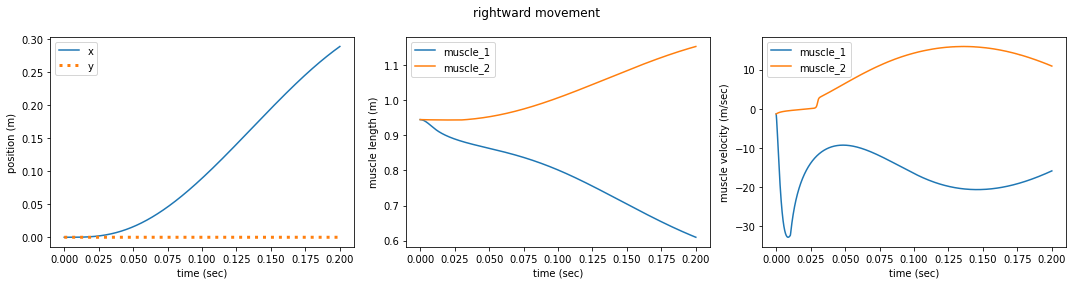

In [26]:


skeleton = mn.plants.skeletons.PointMass(space_dim=2)
muscle_type = mn.plants.muscles.CompliantTendonHillMuscle()
plant = mn.plants.Plant(skeleton=skeleton, muscle_type=muscle_type, timestep=0.0001, integration_method='rk4')

# we create a tug-of-war plant
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[6,0], [0,0]],
                 max_isometric_force=100, tendon_length=5, optimal_muscle_length=0.8)

plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-6,0], [0,0]],
                 max_isometric_force=100, tendon_length=5, optimal_muscle_length=0.8)


# custom plotting function
def plot_tow(j_state, m_state, plant, movement_duration):
    t_fn = np.arange(0., movement_duration + plant.dt, plant.dt)

    plt.subplot(131)
    plt.plot(t_fn, j_state[:, 0], label='x')
    plt.plot(t_fn, j_state[:, 1], label='y', linestyle=':', linewidth=3)
    plt.ylabel('position (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(132)
    plt.plot(t_fn, m_state[:, 1, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, m_state[:, 1, 1], label=plant.muscle_name[1])
    plt.ylabel('muscle length (m)')
    plt.xlabel('time (sec)')
    plt.legend()

    plt.subplot(133)
    plt.plot(t_fn, m_state[:, 2, 0], label=plant.muscle_name[0])
    plt.plot(t_fn, m_state[:, 2, 1], label=plant.muscle_name[1])
    plt.ylabel('muscle velocity (m/sec)')
    plt.xlabel('time (sec)')
    plt.legend()



t_end = 0.2
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, _ = simulate_motion(plant, [0.5, 0.], t_end)
plot_tow(joint_state, muscle_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()


And finally, we create an isometric co-contraction. Muscle lengths and velocities vary over time, while position does not move. This indicates that the musculotendon complex tenses up in an isometric fashion.

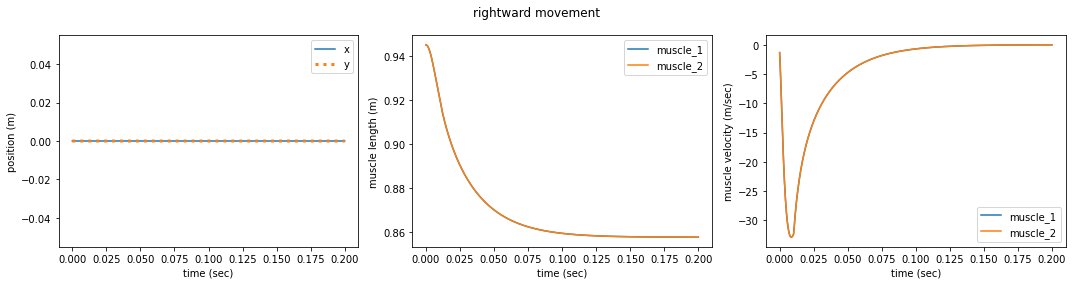

In [27]:

t_end = 0.2
plt.figure(figsize=(15, 4)).set_tight_layout(True)
joint_state, muscle_state, _ = simulate_motion(plant, [0.5, 0.5], t_end)
plot_tow(joint_state, muscle_state, plant, t_end)
plt.suptitle('rightward movement')
plt.show()
